In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import copy, deepcopy

In [2]:
from fastai.basics import *


In [3]:
def load_data(batch_size=64):
  path = untar_data(URLs.IMAGENETTE)
  dir = [x for x in path.iterdir()]
  transform = transforms.Compose(
      [transforms.Resize([224,224]),
   #    transforms.Scale(224),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]
  )
  data_train = datasets.ImageFolder(root=dir[0], transform=transform)
  train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

  data_val = datasets.ImageFolder(root=dir[1], transform=transform)
  val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

  return train_loader, val_loader

In [10]:
train_loader, val_loader = load_data(batch_size=64)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}


In [ ]:
print(dataset_sizes)

{'train': 9469, 'val': 3925}


In [5]:
num_classes = 10
num_epochs = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
def show_img(img, label):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.title('label: {}'.format(label))
  plt.imshow(img)

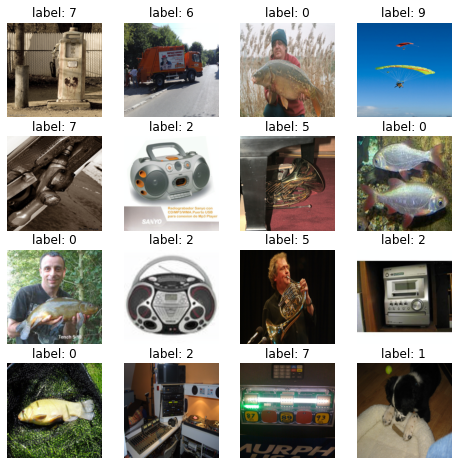

In [ ]:
fig = plt.figure(figsize=(8,8))
columns = 4;
rows = 4;
for i in range(1, columns*rows+1):
    index = np.random.randint(len(val_loader.dataset))
    img, label = val_loader.dataset[index]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    show_img(img, label)



In [6]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes):
  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0

      for inputs, labels in dataloaders[phase]:
        inputs = Variable(inputs.to(device))
        labels = Variable(labels.to(device))
        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  
  #      print('labels: {}\n preds: {}'.format(labels, preds.data)) 
        loss = criterion(outputs, labels)
        if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(labels == preds.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]

      print('{} loss: {:.4f}, acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    print()
  return model

          


In [7]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
  param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes)
resnet = resnet.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

In [11]:
resnet10 = train_model(resnet, criterion, optimizer, dataloaders, dataset_sizes);


train loss: 0.5620, acc: 0.9177
val loss: 0.1475, acc: 0.9873



In [ ]:
def est_accuracy(model, dataloader):
  running_correct = 0
  model.eval()
  for inputs, labels in dataloader:
    inputs = Variable(inputs.to(device))
    labels = Variable(labels.to(device))
    outputs = model(inputs)
    print(outputs)
    _, preds = torch.max(outputs, 1)
    running_correct += torch.sum(labels == preds.data)
  acc = running_correct.double() / len(dataloader.dataset)
  return acc

In [ ]:
logits_model = nn.Sequential(*list(deepcopy(resnet10).children())[:-1]).cuda()
last_layer = nn.Sequential(*list(deepcopy(resnet10).children())[-1:]).cuda()

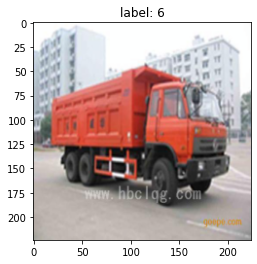

In [12]:
index1 = np.random.randint(len(val_loader.dataset))
img1, label1 = val_loader.dataset[index1]
image1 = Variable(torch.Tensor(img1)).unsqueeze(0)
image1 = image1.to(device)
show_img(img1, label1)

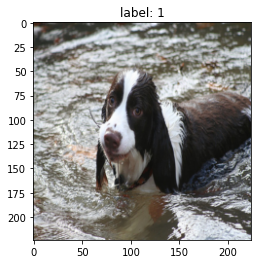

In [14]:
index2 = np.random.randint(len(val_loader.dataset))
img2, label2 = val_loader.dataset[index2]
image2 = Variable(torch.Tensor(img2)).unsqueeze(0)
image2 = image2.to(device)
show_img(img2, label2)

In [24]:
def attack(model, input, target, num_iter=1000, alpha=0.005):
  model.eval()
  loss_history = []
  with torch.set_grad_enabled(True):
    img = deepcopy(input)
    output_targ = model(target)
    best_loss = 10000.
    best_img = img
    img = Variable(img, requires_grad=True)
    for i in range(num_iter):
      
  #    print(img.requires_grad, [x.requires_grad for x in model.parameters()])
      output = model(img)
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)
#      loss_history.append(loss)
      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = img
      img.data -= alpha * torch.sigmoid(img.grad.data)
  #    print(torch.norm(img.grad.data))
      print(loss.item())

  return best_img, loss_history



In [25]:
img, loss_history = attack(resnet10, image1, image2, num_iter=2000, alpha=0.005)
plt.show(loss_history)

10.409523963928223
10.407386779785156
10.402592658996582
10.395174026489258
10.385174751281738
10.372705459594727
10.357808113098145
10.340219497680664
10.319673538208008
10.296175003051758
10.270567893981934
10.242536544799805
10.211114883422852
10.17682933807373
10.140931129455566
10.105389595031738
10.06995677947998
10.033907890319824
9.997989654541016
9.960437774658203
9.922684669494629
9.884469032287598
9.845534324645996
9.807291984558105
9.768750190734863
9.72895622253418
9.68798542022705
9.645892143249512
9.603765487670898
9.560108184814453
9.515456199645996
9.471067428588867
9.426569938659668
9.38259220123291
9.338109970092773
9.293880462646484
9.25061321258545
9.20860481262207
9.166536331176758
9.125456809997559
9.085637092590332
9.046751022338867
9.008929252624512
8.972153663635254
8.936050415039062
8.899767875671387
8.863424301147461
8.827136039733887
8.790897369384766
8.75488567352295
8.718873977661133
8.683197975158691
8.647512435913086
8.612460136413574
8.57778263092041
8

In [ ]:
print(img.data)

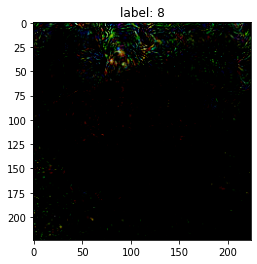

In [26]:
outputs = resnet10(img)
_, preds = torch.max(outputs, 1)
show_img(torch.reshape(img.data.cpu(), (3, 224, 224)), preds.item())

In [ ]:
output1 = logits_model(image1)
#output1 = torch.reshape(output1, (2048,))
probabilities1 = resnet10(image1)
_, preds1 = torch.max(probabilities1, 1)
#print(output1)

output2 = logits_model(image2)
#output2 = torch.reshape(output2, (2048,))
probabilities2 = resnet10(image2)
_, preds2 = torch.max(probabilities2, 1)
#print(output2)

output_mix = torch.cat((output1[:,:10,:,:], output2[:,10:,:,:]), dim=1)
print(output_mix.size(), output1.size())
probabilities_mix = last_layer(Variable(torch.reshape(output_mix, (2048,))))
_, preds_mix = torch.max(torch.reshape(probabilities_mix, (1,10)), 1)

print('prob1: ', probabilities1.tolist()[0])
print('prob2: ', probabilities2.tolist()[0])
print('prob mix: ', probabilities_mix.tolist())
print('Predict1: {}, predict2: {}, predict mix: {}'.format(preds1.data[0], preds2.data[0], preds_mix.data[0]))



torch.Size([1, 2048, 1, 1]) torch.Size([1, 2048, 1, 1])
prob1:  [-1.1195263862609863, -0.7939496040344238, 0.108113132417202, 1.0042184591293335, 0.910085916519165, 1.6284679174423218, -0.23260831832885742, -0.5850721597671509, -0.22364670038223267, 0.9672866463661194]
prob2:  [-1.6726691722869873, -1.5500898361206055, -0.643300473690033, 0.15413415431976318, 5.854814529418945, -1.0113492012023926, 0.8917341232299805, 1.0442852973937988, -0.2804819941520691, 0.9018564820289612]
prob mix:  [-1.6906410455703735, -1.548452615737915, -0.6257829070091248, 0.16699224710464478, 5.855213165283203, -1.0113095045089722, 0.920951247215271, 1.020240306854248, -0.29162731766700745, 0.8926315307617188]
Predict1: 5, predict2: 4, predict mix: 4


In [ ]:
output1_copy = deepcopy(output1)
output1_copy = torch.reshape(output1, (2048,))

output2_copy = deepcopy(output2)
output2_copy = torch.reshape(output2, (2048,))

output_mix = output2_copy
for i in range(num_classes):
  k = torch.argmax(output1_copy)
  output_mix.data[k] = output1_copy.data[k]
  output1_copy[k] = -1
print(output_mix.size(), output1.size())
probabilities_mix = last_layer(Variable(torch.reshape(output_mix, (2048,))))
_, preds_mix = torch.max(torch.reshape(probabilities_mix, (1,10)), 1)

print('prob1: ', probabilities1.tolist()[0])
print('prob2: ', probabilities2.tolist()[0])
print('prob mix: ', probabilities_mix.tolist())
print('Predict1: {}, predict2: {}, predict mix: {}'.format(preds1.data[0], preds2.data[0], preds_mix.data[0]))
print(preds1)



torch.Size([2048]) torch.Size([1, 2048, 1, 1])
prob1:  [-1.1195263862609863, -0.7939496040344238, 0.108113132417202, 1.0042184591293335, 0.910085916519165, 1.6284679174423218, -0.23260831832885742, -0.5850721597671509, -0.22364670038223267, 0.9672866463661194]
prob2:  [-1.6726691722869873, -1.5500898361206055, -0.643300473690033, 0.15413415431976318, 5.854814529418945, -1.0113492012023926, 0.8917341232299805, 1.0442852973937988, -0.2804819941520691, 0.9018564820289612]
prob mix:  [-1.8361175060272217, -1.6345306634902954, -0.6935768723487854, 0.18671658635139465, 6.015265941619873, -0.8487069606781006, 0.8600716590881348, 0.9010728001594543, -0.24180500209331512, 0.8528196215629578]
Predict1: 5, predict2: 4, predict mix: 4
tensor([5], device='cuda:0')
